In [2]:
import itertools
import joblib
import numpy as np
import pandas
import sklearn
import matplotlib.pyplot as plt
from sklearn import tree, svm, ensemble, linear_model, model_selection, metrics, preprocessing, base
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from tqdm import tqdm_notebook

In [3]:
data_df = pandas.read_csv('data/creditcard.csv')
data_df['Time'] = data_df['Time'] % 86400
train_df, test_df = sklearn.model_selection.train_test_split(data_df, test_size = 0.20, random_state=1)

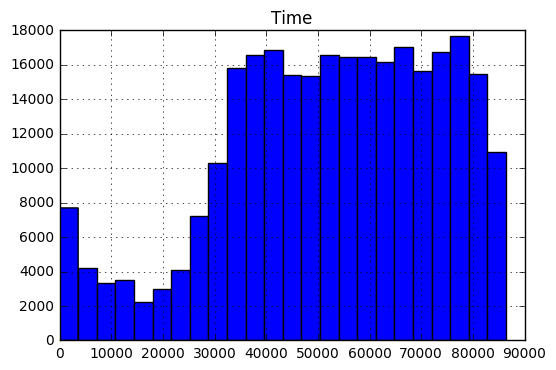

In [4]:
plt.figure()
data_df.hist(column='Time', bins=24)
plt.show()

In [5]:
X_train = train_df.ix[:, 0:30].as_matrix()
y_train = train_df.ix[:, 30].as_matrix().astype(int)

X_test = test_df.ix[:, 0:30].as_matrix()
y_test = test_df.ix[:, 30].as_matrix().astype(int)

In [6]:
def aucpr(estimator, X, y):
    y_pred = estimator.predict(X)
    return metrics.average_precision_score(y, y_pred)

In [7]:
def evaluate(test, pred):
    return {"Recall" : metrics.recall_score(test, pred),
            "Precision" : metrics.precision_score(test, pred),
            "AUC": metrics.roc_auc_score(test, pred), 
            "AUCPR": metrics.average_precision_score(test, pred), 
            "F1": metrics.f1_score(test, pred),
            "Accuracy": metrics.accuracy_score(test, pred)}

In [8]:
def formatted_evaluate(test, pred):
    d = evaluate(test, pred)
    print("%.4f & %.4f & %.4f & %.4f" % (d['Precision'], d['Recall'], d['F1'],  d['AUCPR']))

In [9]:
def plot_cnf_matrix(test, pred, normalize=False):
    cm = metrics.confusion_matrix(test, pred)
    classes = ['Legitimate', 'Fraudulent']
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [20]:
sm = SMOTE(random_state=1)
rus = RandomUnderSampler(random_state=1)
ros = RandomOverSampler(random_state=1)

In [24]:
def train_and_test_model(classifier, sampler, scale_features=False):
    ret = []
    if sampler:
        sampled_X_train, sampled_y_train = sampler.fit_sample(X_train, y_train)
    else:
        sampled_X_train, sampled_y_train = X_train, y_train
    if scale_features:
        scaler = preprocessing.StandardScaler().fit(sampled_X_train)
        sampled_X_train = scaler.transform(sampled_X_train)
        sampled_X_test = scaler.transform(X_test)
        classifier.fit(sampled_X_train, sampled_y_train)
        y_pred = classifier.predict(sampled_X_test)
    else: 
        classifier.fit(sampled_X_train, sampled_y_train)
        y_pred = classifier.predict(X_test)
    ret.append((classifier, sampler, evaluate(y_test, y_pred)))
    plot_cnf_matrix(y_test, y_pred)
    formatted_evaluate(y_test, y_pred)
    return ret

In [11]:
for sampler in [None, rus, ros, sm]:
    if not sampler:
        pipeline = Pipeline([('lr', linear_model.LogisticRegression(n_jobs=-1))])
    else:
        pipeline = Pipeline([('sampler', sampler), ('lr', linear_model.LogisticRegression(n_jobs=-1))])

    parameters = {'lr__C':[.0001, .001, .01, .1, .5, .75, 1, 2.5, 5, 10]}
    gscv = model_selection.GridSearchCV(cv=3, error_score='raise', n_jobs=-1,
                                 scoring=aucpr, 
                                 verbose=True,
                                 estimator=pipeline, 
                                 param_grid=parameters)
    gscv.fit(X_train, y_train)
    print(gscv.best_estimator_)
    print(gscv.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   19.1s finished


Pipeline(steps=[('lr', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
0.745028411808
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.5s finished


Pipeline(steps=[('sampler', RandomUnderSampler(random_state=1, ratio='auto', replacement=True,
          return_indices=False)), ('lr', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
0.475684173171
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.9s finished


Pipeline(steps=[('sampler', RandomOverSampler(random_state=1, ratio='auto')), ('lr', LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
0.476880471482
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.9s finished


Pipeline(steps=[('sampler', SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=1,
   ratio='auto')), ('lr', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
0.488895030887


Confusion matrix, without normalization


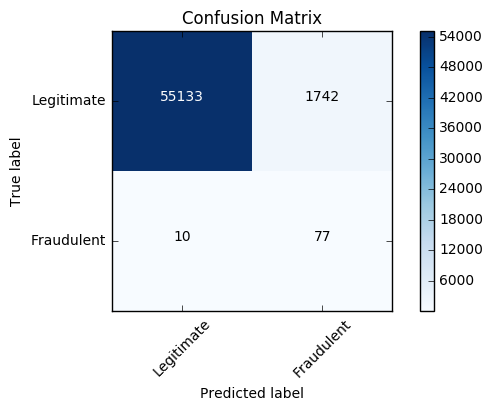

0.0423 & 0.8851 & 0.0808 & 0.4638


[(LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  RandomUnderSampler(random_state=1, ratio='auto', replacement=True,
            return_indices=False),
  {'AUC': 0.92721444991789814,
   'AUCPR': 0.46378198898498285,
   'Accuracy': 0.96924265299673462,
   'F1': 0.080797481636935994,
   'Precision': 0.042330951072017592,
   'Recall': 0.88505747126436785})]

In [25]:
train_and_test_model(linear_model.LogisticRegression(C=.01, n_jobs=-1), rus)

Confusion matrix, without normalization


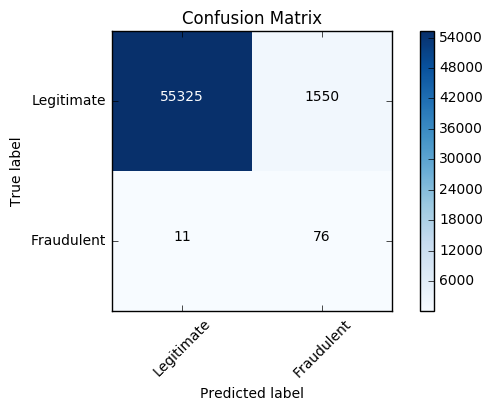

0.0467 & 0.8736 & 0.0887 & 0.4602


[(LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  RandomOverSampler(random_state=1, ratio='auto'),
  {'AUC': 0.92315523556902856,
   'AUCPR': 0.46024839849620852,
   'Accuracy': 0.972595765598118,
   'F1': 0.088733216579100993,
   'Precision': 0.046740467404674045,
   'Recall': 0.87356321839080464})]

In [26]:
train_and_test_model(linear_model.LogisticRegression(C=.01, n_jobs=-1), ros)

Confusion matrix, without normalization


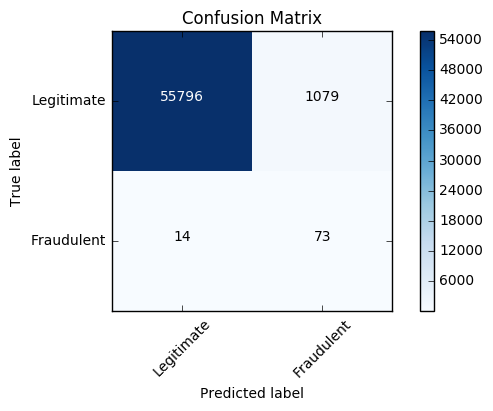

0.0634 & 0.8391 & 0.1178 & 0.4513


[(LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=1,
     ratio='auto'),
  {'AUC': 0.91005451559934325,
   'AUCPR': 0.45134714660634145,
   'Accuracy': 0.98081176924967517,
   'F1': 0.11783696529459241,
   'Precision': 0.063368055555555552,
   'Recall': 0.83908045977011492})]

In [27]:
train_and_test_model(linear_model.LogisticRegression(C=1, n_jobs=-1), sm)

In [18]:
sm = SMOTE(random_state=1)
rus = RandomUnderSampler(random_state=1)
ros = RandomOverSampler(random_state=1)
parameters = {'cl__max_depth':[1, 3, 5, 10, 20, 50, 100, None], 'cl__criterion':['gini','entropy']}
for sampler in [None, rus, ros, sm]:
    if not sampler:
        pipeline = Pipeline([('cl', tree.DecisionTreeClassifier())])
    else:
        pipeline = Pipeline([('sampler', sampler), ('cl', tree.DecisionTreeClassifier())])

    gscv = model_selection.GridSearchCV(cv=3, error_score='raise', n_jobs=-1,
                                 scoring=aucpr, 
                                 verbose=True,
                                 estimator=pipeline, 
                                 param_grid=parameters)
    gscv.fit(X_train, y_train)
    print(gscv.best_estimator_)
    print(gscv.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  34 out of  48 | elapsed:   30.6s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   40.6s finished


Pipeline(steps=[('cl', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
0.840924925574
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  34 out of  48 | elapsed:    4.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    5.5s finished


Pipeline(steps=[('sampler', RandomUnderSampler(random_state=1, ratio='auto', replacement=True,
          return_indices=False)), ('cl', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
0.469832786023
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  34 out of  48 | elapsed:   29.0s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   37.4s finished


Pipeline(steps=[('sampler', RandomOverSampler(random_state=1, ratio='auto')), ('cl', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
0.769220013326
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  34 out of  48 | elapsed:  1.3min remaining:   33.3s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.8min finished


Pipeline(steps=[('sampler', SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=1,
   ratio='auto')), ('cl', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
0.62696572586


Confusion matrix, without normalization


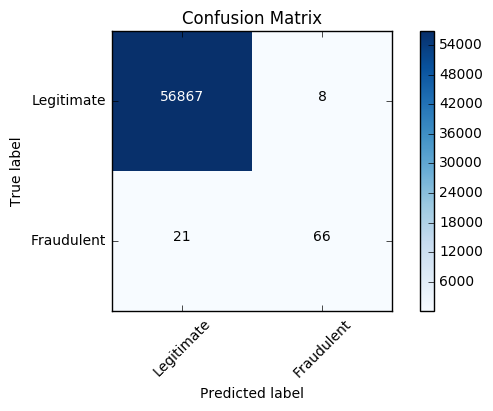

0.8919 & 0.7586 & 0.8199 & 0.8254


[(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              presort=False, random_state=None, splitter='best'),
  None,
  {'AUC': 0.87924001515725658,
   'AUCPR': 0.82544062418879138,
   'Accuracy': 0.99949088866261715,
   'F1': 0.81987577639751552,
   'Precision': 0.89189189189189189,
   'Recall': 0.75862068965517238})]

In [31]:
train_and_test_model(tree.DecisionTreeClassifier(max_depth=5, criterion='gini'), None)

Confusion matrix, without normalization


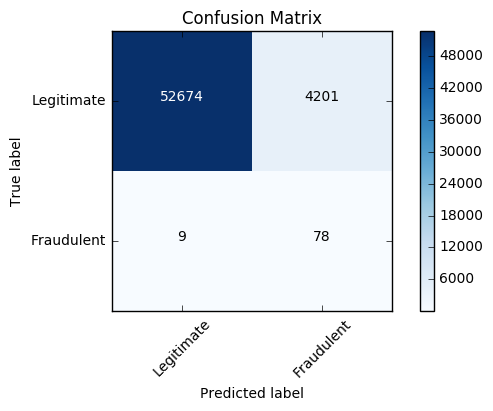

0.0182 & 0.8966 & 0.0357 & 0.4575


[(DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              presort=False, random_state=None, splitter='best'),
  RandomUnderSampler(random_state=1, ratio='auto', replacement=True,
            return_indices=False),
  {'AUC': 0.91134399393709753,
   'AUCPR': 0.45746914114123488,
   'Accuracy': 0.92609107826270143,
   'F1': 0.035730645900137428,
   'Precision': 0.01822855807431643,
   'Recall': 0.89655172413793105})]

In [32]:
train_and_test_model(tree.DecisionTreeClassifier(max_depth=3, criterion='entropy'), rus)

Confusion matrix, without normalization


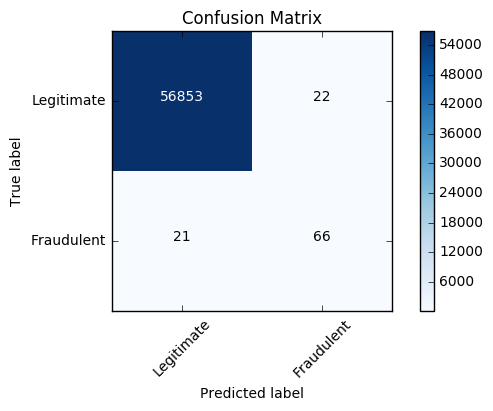

0.7500 & 0.7586 & 0.7543 & 0.7545


[(DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=50,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              presort=False, random_state=None, splitter='best'),
  RandomOverSampler(random_state=1, ratio='auto'),
  {'AUC': 0.87911693823417958,
   'AUCPR': 0.75449467824284544,
   'Accuracy': 0.99924511077560474,
   'F1': 0.75428571428571423,
   'Precision': 0.75,
   'Recall': 0.75862068965517238})]

In [33]:
train_and_test_model(tree.DecisionTreeClassifier(max_depth=50, criterion='entropy'), ros)

Confusion matrix, without normalization


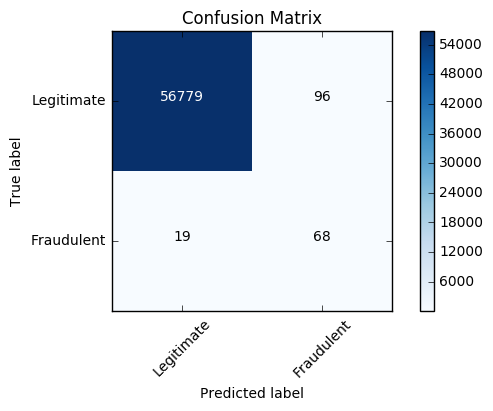

0.4146 & 0.7816 & 0.5418 & 0.5983


[(DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=50,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              presort=False, random_state=None, splitter='best'),
  SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=1,
     ratio='auto'),
  {'AUC': 0.88996064165719335,
   'AUCPR': 0.5982884487237824,
   'Accuracy': 0.99798111021382674,
   'F1': 0.54183266932270913,
   'Precision': 0.41463414634146339,
   'Recall': 0.7816091954022989})]

In [34]:
train_and_test_model(tree.DecisionTreeClassifier(max_depth=50, criterion='entropy'), sm)

In [29]:
sm = SMOTE(random_state=1)
rus = RandomUnderSampler(random_state=1)
ros = RandomOverSampler(random_state=1)
parameters = {'cl__max_depth':[5, 10, 20, 50, None], 'cl__n_estimators':[10, 100, 500]}
for sampler in [None, rus, ros, sm]:
    if not sampler:
        pipeline = Pipeline([('cl', ensemble.RandomForestClassifier(n_jobs=-1))])
    else:
        pipeline = Pipeline([('sampler', sampler), ('cl', ensemble.RandomForestClassifier(n_jobs=-1))])

    gscv = model_selection.GridSearchCV(cv=3, error_score='raise', n_jobs=-1,
                                 scoring=aucpr, 
                                 verbose=True,
                                 estimator=pipeline, 
                                 param_grid=parameters)
    gscv.fit(X_train, y_train)
    print(gscv.best_estimator_)
    print(gscv.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  28 out of  45 | elapsed:  4.5min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 10.2min finished


Pipeline(steps=[('cl', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False))])
0.856544767864
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  28 out of  45 | elapsed:   10.9s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   20.4s finished


Pipeline(steps=[('sampler', RandomUnderSampler(random_state=1, ratio='auto', replacement=True,
          return_indices=False)), ('cl', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split...ators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False))])
0.489916170069
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  28 out of  45 | elapsed:  5.7min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 11.7min finished


Pipeline(steps=[('sampler', RandomOverSampler(random_state=1, ratio='auto')), ('cl', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False))])
0.862053881619
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  28 out of  45 | elapsed:  9.4min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 19.1min finished


Pipeline(steps=[('sampler', SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=1,
   ratio='auto')), ('cl', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07,...ators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False))])
0.858707705842


Confusion matrix, without normalization


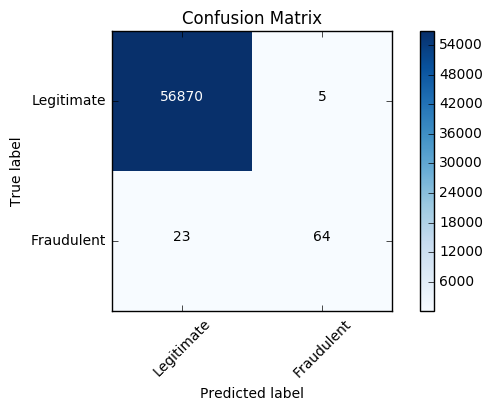

0.9275 & 0.7356 & 0.8205 & 0.8318


[(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, n_jobs=-1, oob_score=False,
              random_state=None, verbose=0, warm_start=False),
  None,
  {'AUC': 0.86777213591006697,
   'AUCPR': 0.83178609687466931,
   'Accuracy': 0.99950844422597518,
   'F1': 0.82051282051282048,
   'Precision': 0.92753623188405798,
   'Recall': 0.73563218390804597})]

In [35]:
train_and_test_model(ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=None), None)

Confusion matrix, without normalization


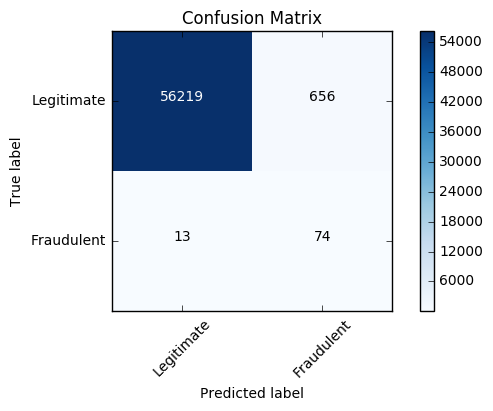

0.1014 & 0.8506 & 0.1812 & 0.4761


[(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=5, max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, n_jobs=-1, oob_score=False,
              random_state=None, verbose=0, warm_start=False),
  RandomUnderSampler(random_state=1, ratio='auto', replacement=True,
            return_indices=False),
  {'AUC': 0.91952032335480616,
   'AUCPR': 0.47608639899051552,
   'Accuracy': 0.98825532811347916,
   'F1': 0.18115055079559361,
   'Precision': 0.10136986301369863,
   'Recall': 0.85057471264367812})]

In [36]:
train_and_test_model(ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=500, max_depth=5), rus)

Confusion matrix, without normalization


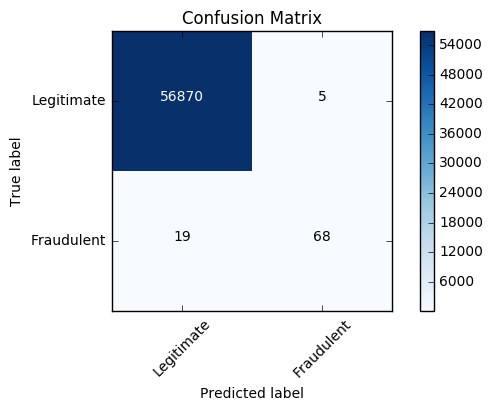

0.9315 & 0.7816 & 0.8500 & 0.8567


[(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=50, max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, n_jobs=-1, oob_score=False,
              random_state=None, verbose=0, warm_start=False),
  RandomOverSampler(random_state=1, ratio='auto'),
  {'AUC': 0.89076064165719337,
   'AUCPR': 0.85672480021058495,
   'Accuracy': 0.9995786664794073,
   'F1': 0.84999999999999998,
   'Precision': 0.93150684931506844,
   'Recall': 0.7816091954022989})]

In [37]:
train_and_test_model(ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=500, max_depth=50), ros)

Confusion matrix, without normalization


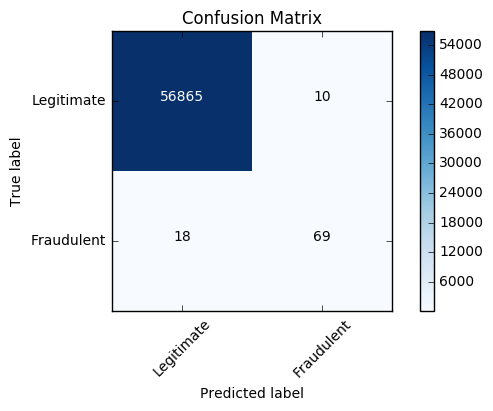

0.8734 & 0.7931 & 0.8313 & 0.8334


[(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=50, max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, n_jobs=-1, oob_score=False,
              random_state=None, verbose=0, warm_start=False),
  SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=1,
     ratio='auto'),
  {'AUC': 0.8964638120500189,
   'AUCPR': 0.83341858496764698,
   'Accuracy': 0.99950844422597518,
   'F1': 0.83132530120481929,
   'Precision': 0.87341772151898733,
   'Recall': 0.7931034482758621})]

In [38]:
train_and_test_model(ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=50), sm)

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


None
Confusion matrix, without normalization


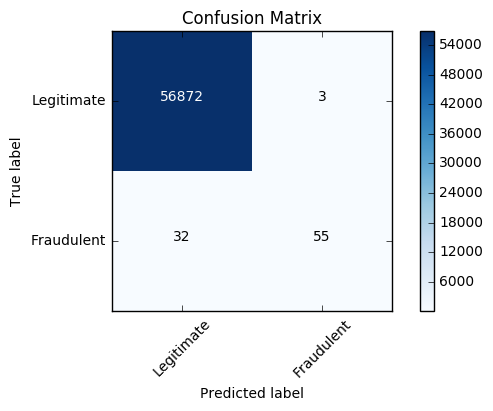

RandomUnderSampler(random_state=1, ratio='auto', replacement=True,
          return_indices=False)
Confusion matrix, without normalization


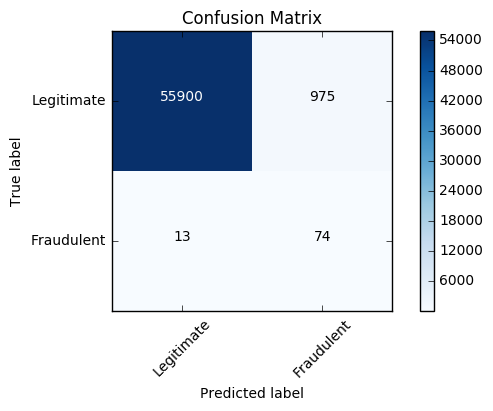

None
0.9483 & 0.6322 & 0.7586 & 0.7905
RandomUnderSampler(random_state=1, ratio='auto', replacement=True,
          return_indices=False)
0.0705 & 0.8506 & 0.1303 & 0.4607


In [30]:
ret = train_and_test_model(svm.SVC(max_iter=5000, cache_size=50000), True)
for i in ret:
    print(i[1])
    print("%.4f & %.4f & %.4f & %.4f" % (i[2]['Precision'], i[2]['Recall'], i[2]['F1'],  i[2]['AUCPR']))

None
Confusion matrix, without normalization


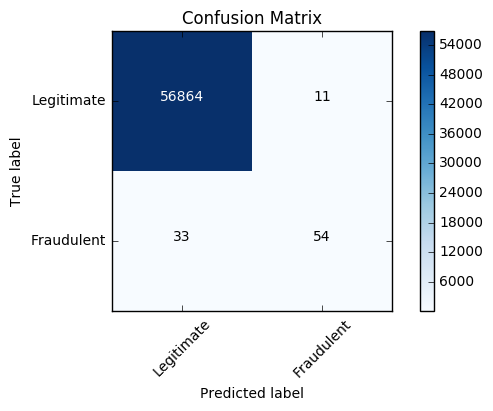

SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=1,
   ratio='auto')
Confusion matrix, without normalization


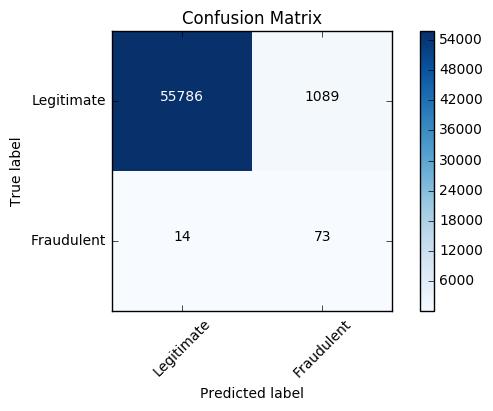

RandomUnderSampler(random_state=1, ratio='auto', replacement=True,
          return_indices=False)
Confusion matrix, without normalization


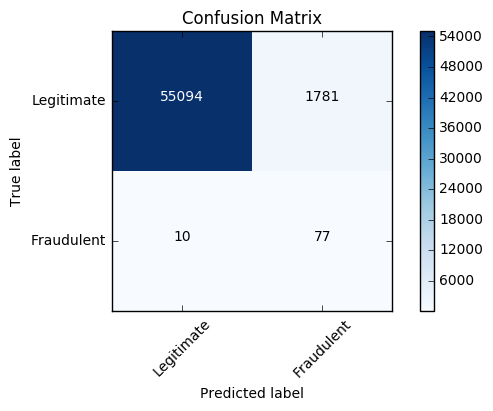

RandomOverSampler(random_state=1, ratio='auto')
Confusion matrix, without normalization


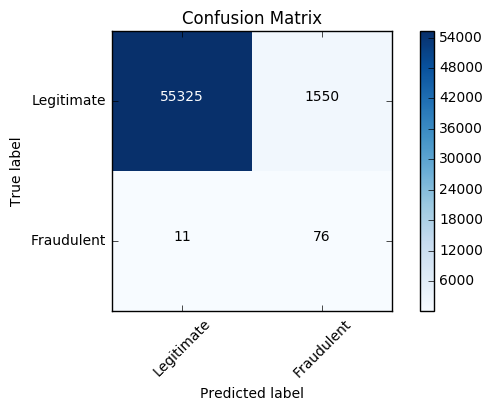

None
0.8308 & 0.6207 & 0.7105 & 0.7260
SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=1,
   ratio='auto')
0.0628 & 0.8391 & 0.1169 & 0.4511
RandomUnderSampler(random_state=1, ratio='auto', replacement=True,
          return_indices=False)
0.0414 & 0.8851 & 0.0792 & 0.4633
RandomOverSampler(random_state=1, ratio='auto')
0.0467 & 0.8736 & 0.0887 & 0.4602


In [45]:
ret = train_and_test_model(linear_model.LogisticRegression(C=.1, n_jobs=-1))
for i in ret:
    print(i[1])
    print("%.4f & %.4f & %.4f & %.4f" % (i[2]['Precision'], i[2]['Recall'], i[2]['F1'],  i[2]['AUCPR']))

In [252]:
for i in tmp:
    print(i[1])
    print("%.4f & %.4f & %.4f & %.4f" % (i[2]['Precision'], i[2]['Recall'], i[2]['F1'],  i[2]['AUC']))

None
0.6092 & 0.8413 & 0.7067 & 0.9203
SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=1,
   ratio='auto')
0.8391 & 0.0634 & 0.1178 & 0.5316
RandomUnderSampler(random_state=1, ratio='auto', replacement=True,
          return_indices=False)
0.8851 & 0.0412 & 0.0788 & 0.5205
RandomOverSampler(random_state=1, ratio='auto')
0.8736 & 0.0467 & 0.0887 & 0.5233


None
Confusion matrix, without normalization


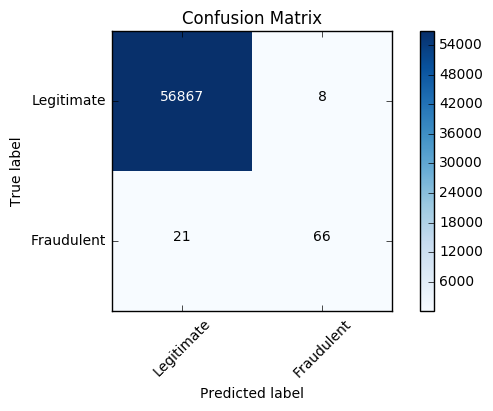

SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=1,
   ratio='auto')
Confusion matrix, without normalization


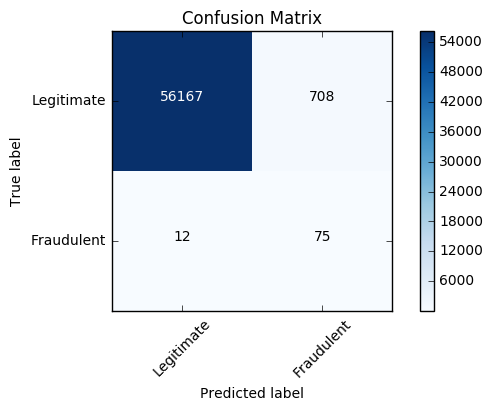

RandomUnderSampler(random_state=1, ratio='auto', replacement=True,
          return_indices=False)
Confusion matrix, without normalization


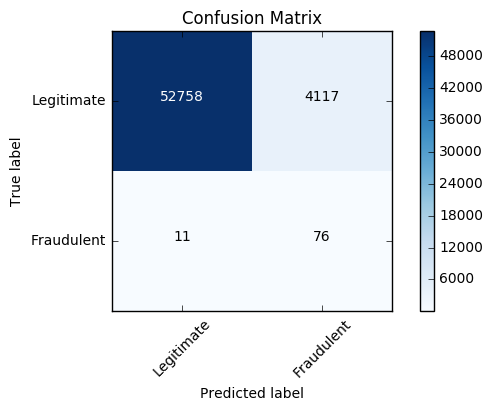

RandomOverSampler(random_state=1, ratio='auto')
Confusion matrix, without normalization


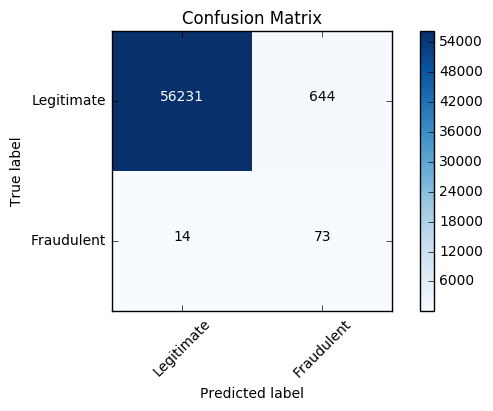

None
0.8919 & 0.7586 & 0.8199 & 0.8254
SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=1,
   ratio='auto')
0.0958 & 0.8621 & 0.1724 & 0.4790
RandomUnderSampler(random_state=1, ratio='auto', replacement=True,
          return_indices=False)
0.0181 & 0.8736 & 0.0355 & 0.4459
RandomOverSampler(random_state=1, ratio='auto')
0.1018 & 0.8391 & 0.1816 & 0.4706


In [39]:
ret = train_and_test_model(tree.DecisionTreeClassifier(max_depth=5, criterion='gini'))
for i in ret:
    print(i[1])
    print("%.4f & %.4f & %.4f & %.4f" % (i[2]['Precision'], i[2]['Recall'], i[2]['F1'],  i[2]['AUCPR']))

None
Confusion matrix, without normalization


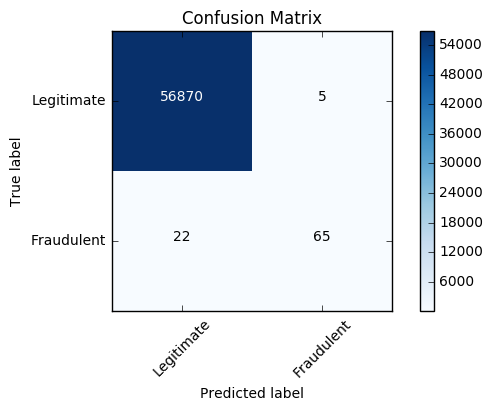

SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=1,
   ratio='auto')
Confusion matrix, without normalization


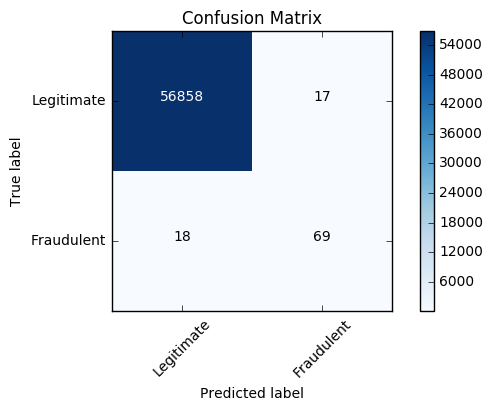

RandomUnderSampler(random_state=1, ratio='auto', replacement=True,
          return_indices=False)
Confusion matrix, without normalization


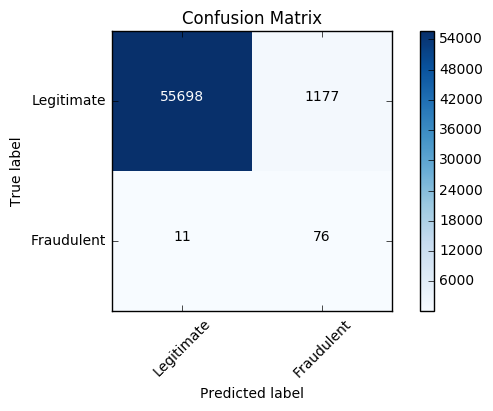

RandomOverSampler(random_state=1, ratio='auto')
Confusion matrix, without normalization


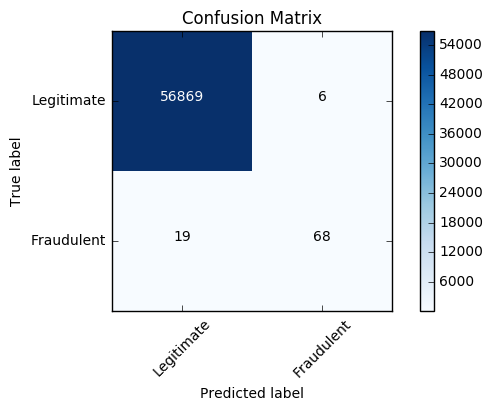

None
0.9286 & 0.7471 & 0.8280 & 0.8380
SMOTE(k=5, kind='regular', m=10, n_jobs=-1, out_step=0.5, random_state=1,
   ratio='auto')
0.8023 & 0.7931 & 0.7977 & 0.7979
RandomUnderSampler(random_state=1, ratio='auto', replacement=True,
          return_indices=False)
0.0607 & 0.8736 & 0.1134 & 0.4672
RandomOverSampler(random_state=1, ratio='auto')
0.9189 & 0.7816 & 0.8447 & 0.8504


In [258]:
ret = train_and_test_model(ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=20))
for i in ret:
    print(i[1])
    print("%.4f & %.4f & %.4f & %.4f" % (i[2]['Precision'], i[2]['Recall'], i[2]['F1'],  i[2]['AUCPR']))

In [12]:
# Hyperparameters
"""
num_estimators=[3, 5, 10, 50, 100, 500, 1000, 5000]
max_depth=[None]


splits = 4
kf = KFold(n_splits=splits)
def run_kfold_validation(estimators, depth):
    sum_recall = 0
    sum_acc = 0
    for validate_train_index, validate_test_index in kf.split(X_train):
        X_validate_train, X_validate_test = X_train[validate_train_index], X_train[validate_test_index]
        Y_validate_train, Y_validate_test = Y_train[validate_train_index], Y_train[validate_test_index]

        rfc = ensemble.RandomForestClassifier(n_estimators=estimators, max_depth=depth, random_state=1, n_jobs=-1)
        rfc.fit(X_validate_train, Y_validate_train)

        Y_predict = rfc.predict(X_validate_test)
        sum_recall += sklearn.metrics.recall_score(Y_validate_test, Y_predict)
        sum_acc += sklearn.metrics.accuracy_score(Y_validate_test, Y_predict)
    return {
            'num_estimators': estimators,
            'max_depth': depth,
            'recall': sum_recall / splits,
            'accuracy': sum_acc / splits
        }
    
results = []
for estimators, depth in tqdm_notebook(itertools.product(num_estimators, max_depth)):
    results.append(run_kfold_validation(estimators, depth))
"""

Exception in thread Thread-1975:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

